# Visión computacional en R

Existen múltiples paquetes de R para hacer manipulación y procesamiento de imágenes

## Manipulación general

- **magick**: Paquete de R que permite usar múltiples funciones de la librería [ImageMagick STL](https://www.imagemagick.org/Magick++/STL.html), la cual es una de las librerías open source más grandes para hacer procesamiento de imágenes.

- **imager**: Paquete de R basado en la librería de procesamiento de imágenes [CImg](http://www.cimg.eu/)

- **Tensorflow R**: Paquete de R que permite usar el framework de Deep Learning Tensorflow desarrollado por Google.

- **keras R**: Paquete de R que permite usar la API de redes neuronales keras. Se puede usa rcomo backend el framework de tensorflow. 

In [17]:
library('repr')
options(repr.plot.width=6, repr.plot.height=4.5)

In [2]:
install_load_library <- function(x){
  for( i in x ){
    if( ! require( i , character.only = TRUE ) ){
      install.packages( i , dependencies = TRUE )
      require( i , character.only = TRUE )
    }
  }
}

In [26]:
install_load_library( c('imager','pixmap','magick'))
install_load_library( c('devtools','dlib'))
install_load_library( c('knitr','ggplot2','dplyr'))

Loading required package: imager
Loading required package: plyr
Loading required package: magrittr

Attaching package: ‘imager’

The following object is masked from ‘package:magrittr’:

    add

The following object is masked from ‘package:plyr’:

    liply

The following objects are masked from ‘package:stats’:

    convolve, spectrum

The following object is masked from ‘package:graphics’:

    frame

The following object is masked from ‘package:base’:

    save.image

Loading required package: pixmap
Loading required package: magick
Linking to ImageMagick 6.9.6.6
Enabled features: cairo, fontconfig, freetype, pango, rsvg, webp
Disabled features: fftw, ghostscript, lcms, x11
Loading required package: devtools
Loading required package: dlib
Loading required package: knitr
Loading required package: ggplot2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,

## 1. Lectura de la imagen

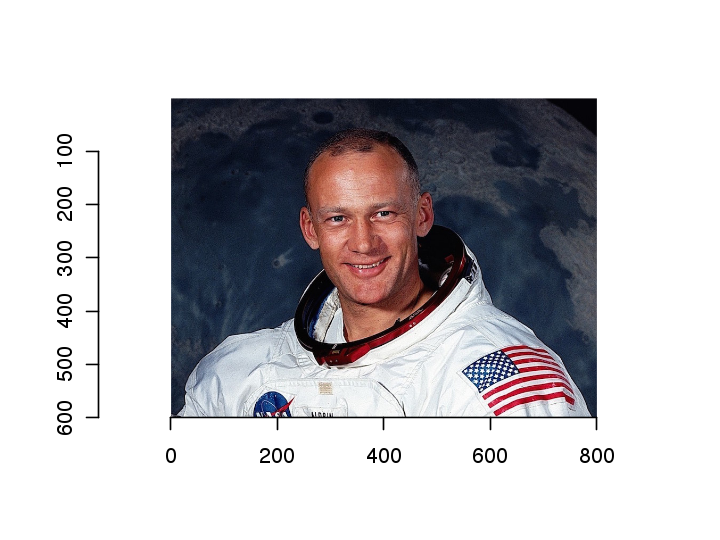

In [27]:
im_file <- 'data/buzz_aldrin.jpg'
image <- load.image(im_file)
plot(image, rescale=FALSE)

Revisamos la clase del objeto image

In [28]:
class(image)

[1] "cimg"         "imager_array" "numeric"

Revisamos las dimensiones de la imagen

In [29]:
dim(image)

[1] 800 600   1   3

## 2. Generación de histograma de color

In [30]:
image_df <- as.data.frame(image)
head(image_df)

x,y,cc,value
1,1,1,0.11764706
2,1,1,0.09411765
3,1,1,0.13725490
4,1,1,0.10588235
5,1,1,0.07843137
6,1,1,0.12156863


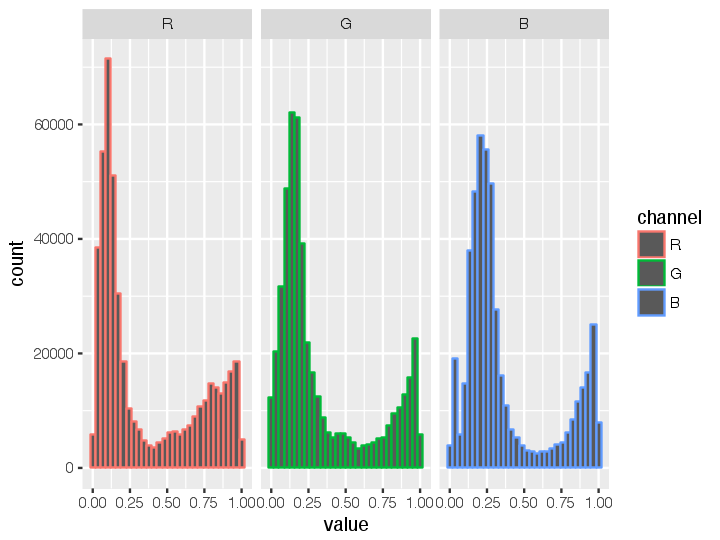

In [31]:
image_df <- dplyr::mutate(image_df,channel=factor(cc,labels=c('R','G','B')))
ggplot(image_df,aes(value,col=channel)) + geom_histogram(bins=30) + facet_wrap(~ channel)

## 3. Detector de bordes

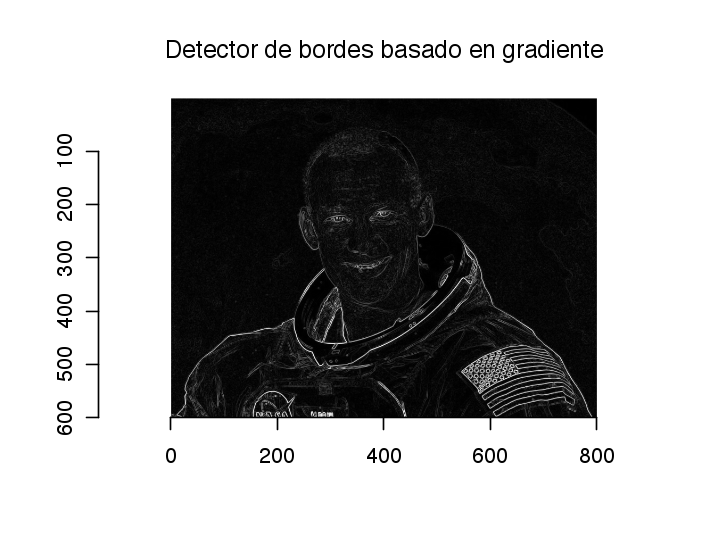

In [32]:
image.g <- grayscale(image)
imgradient(image.g,"xy") %>% enorm %>% plot(main="Detector de bordes basado en gradiente")

Warning message in cannyEdges(image, alpha = 0.5, sigma = 2):
“Running Canny detector on luminance channel”

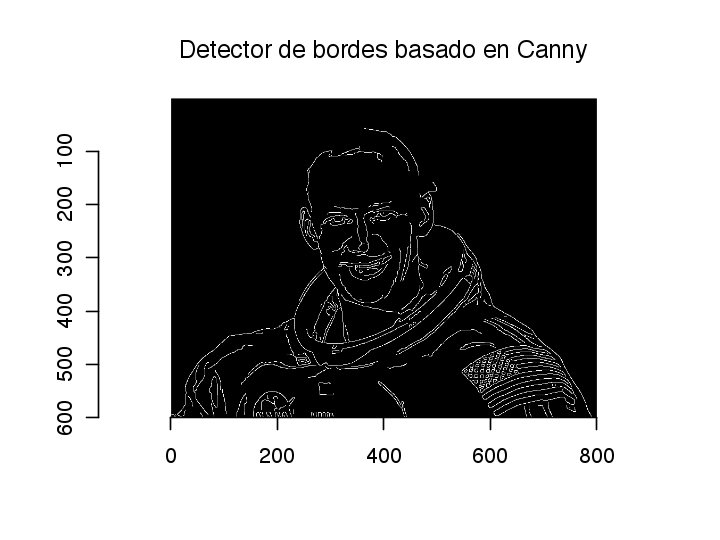

In [33]:
cannyEdges(image, alpha=0.5, sigma=2) %>% plot(main="Detector de bordes basado en Canny")

## 4. Detección de personas y objetos usando Darknet

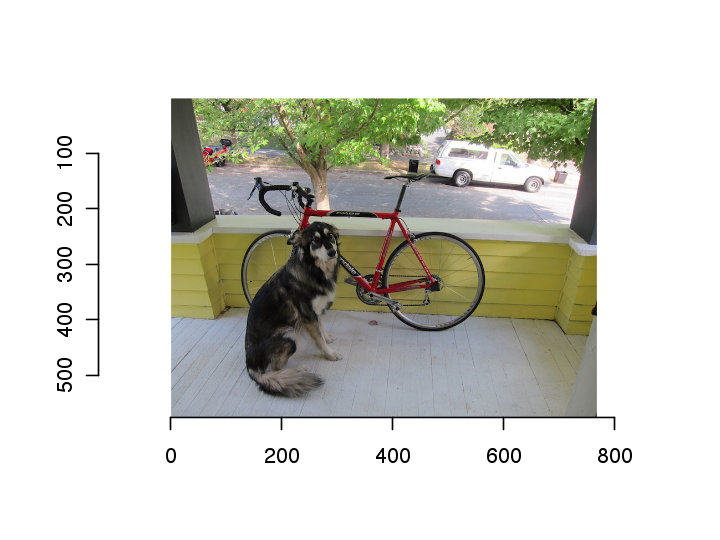

In [34]:
im_file <- 'data/dog.jpg'
image <- load.image(im_file)
plot(image, rescale=FALSE)

In [35]:
devtools::install_github("bnosac/image", subdir = "image.darknet", build_vignettes = TRUE)

Skipping install of 'image.darknet' from a github remote, the SHA1 (badec17b) has not changed since last install.
  Use `force = TRUE` to force installation


In [36]:
library(image.darknet)

In [37]:
model <- system.file(package="image.darknet", "include", "darknet", "cfg", "tiny.cfg")
weights <- system.file(package="image.darknet", "models", "tiny.weights")
labels <- system.file(package="image.darknet", "include", "darknet", "data", "imagenet.shortnames.list")
labels <- readLines(labels)

darknet_tiny <- image_darknet_model(type = 'classify', model = model, weights = weights, labels = labels)

In [38]:
result <- image_darknet_classify(file = im_file, object = darknet_tiny)
result

label,probability
malamute,0.18206641
dogsled,0.12255822
Eskimo dog,0.06975935
collie,0.04245654
Siberian husky,0.03541765


## 5. Uso de Keras y Tensorflow

El dataset "Modified National Institute of Standards and Technology database" (MNIST) es una base de datos de números escritos a mano. Consiste de imágenes en escala de grises de 28 x 28 pixels

![MINST](figures/MNIST.png)

In [39]:
install_load_library(c('keras'))

Instalar la librería de Keras y el framework Tensorflow

In [40]:
library(keras)
#install_keras()

### Lectura del dataset MINST

In [8]:
mnist <- dataset_mnist()
x_train <- mnist$train$x
y_train <- mnist$train$y
x_test <- mnist$test$x
y_test <- mnist$test$y

La variable x es un vector 3D (imagenes, ancho, alto) con valores en escala de grises. Como parte del pre-procesamiento, debemos convertir estos vectores 3D en matrices 2D transformando los ejes de ancho y alto en un solo eje de largo 28x28 = 784 elementos.

In [41]:
# reshape
dim(x_train) <- c(nrow(x_train), 784)
dim(x_test) <- c(nrow(x_test), 784)
# rescale
x_train <- x_train / 255
x_test <- x_test / 255

La variable y es un vector de enteros con el valor verdadero del dígito escrito a mano, el cual va entre 0 y 9. Como parte del pre-procesamiento, transformamos estos vectores en matrices de clases binaria usando la función to_categorical() de Keras.

In [14]:
y_train <- to_categorical(y_train, 10)
y_test <- to_categorical(y_test, 10)

### Definición del modelo

Contruimos un modelo secuencial y agregamos las capas usando el operador %>%

In [43]:
model <- keras_model_sequential() 
model %>% 
  layer_dense(units = 256, activation = 'relu', input_shape = c(784)) %>% 
  layer_dropout(rate = 0.4) %>% 
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 10, activation = 'softmax')

In [44]:
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_4 (Dense)                     (None, 256)                     200960      
________________________________________________________________________________
dropout_3 (Dropout)                 (None, 256)                     0           
________________________________________________________________________________
dense_5 (Dense)                     (None, 128)                     32896       
________________________________________________________________________________
dropout_4 (Dropout)                 (None, 128)                     0           
________________________________________________________________________________
dense_6 (Dense)                     (None, 10)                      1290        
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_____________________________________

Definimos la función de costo, el algoritmo de optimización y las métricas. Compilamos el modelo.

In [45]:
model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

### Entrenamiento y evaluación

In [15]:
history <- model %>% fit(
  x_train, y_train, 
  epochs = 30, batch_size = 128, 
  validation_split = 0.2
)

El objeto history calculado por la función fit() contiene la función de costo y las métricas de precisión.

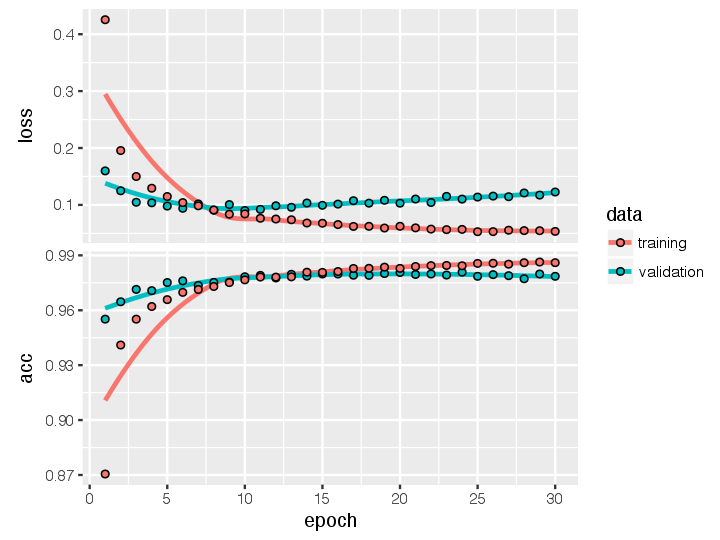

In [46]:
plot(history)

Evaluamos el modelo usando los datos de test

In [19]:
model %>% evaluate(x_test, y_test)

$loss
[1] 0.111136

$acc
[1] 0.979

In [78]:
model %>% predict_classes(x_test) -> result
class(result)
#dim(result)
result[1:10]

[1] "array"

[1] 6 0 6 7 6 6 6 6 4 6

In [76]:
#help(to_categorical)
#y_test

In [83]:
sum(mnist$test$y==result)/length(mnist$test$y)
#sum(10-apply(y_test,MARGIN=1,FUN=which.max)==result)/dim(y_test)[1] -> mean
#mean
#which.max(y_test)

[1] 0.071

In [82]:
#mnist$test$y